# Spark Initialization

In [1]:
# Import findspark to read SPARK_HOME and HADOOP_HOME
import findspark
findspark.init()

In [2]:
# Import required library
from pyspark.sql import SparkSession

# Create Spark Session
spark = SparkSession.builder.appName("Global Commodity Trade Statistics").getOrCreate()

# Print Spark object ID
print(spark)

# Loading Data using Spark

In [3]:
# Dataset could be downloaded at https://www.kaggle.com/unitednations/global-commodity-trade-statistics
df = spark.read.csv("D:/kuliah/bigdata/commodity_trade_statistics_data.csv", header=True, inferSchema=True)

In [4]:
# Print top 20 rows data
df.show()

+---------------+----+---------+--------------------+------+---------+---------+---------------+--------+---------------+
|country_or_area|year|comm_code|           commodity|  flow|trade_usd|weight_kg|  quantity_name|quantity|       category|
+---------------+----+---------+--------------------+------+---------+---------+---------------+--------+---------------+
|    Afghanistan|2016|   010410|         Sheep, live|Export|     6088|     2339|Number of items|      51|01_live_animals|
|    Afghanistan|2016|   010420|         Goats, live|Export|     3958|      984|Number of items|      53|01_live_animals|
|    Afghanistan|2008|   010210|Bovine animals, l...|Import|  1026804|      272|Number of items|    3769|01_live_animals|
|        Albania|2016|   010290|Bovine animals, l...|Import|  2414533|  1114023|Number of items|    6853|01_live_animals|
|        Albania|2016|   010392|Swine, live excep...|Import| 14265937|  9484953|Number of items|   96040|01_live_animals|
|        Albania|2016|  

In [5]:
# Register the DataFrame as a SQL temporary view
df.createOrReplaceTempView("commodity_trade")

# Preparing Data

In [6]:
# Data that used are Country of Area, Commodity Code, Commodity, Flow, and Trade USD, excluded uncategorized comm_code.
data = spark.sql("SELECT country_or_area, comm_code, commodity, flow, trade_usd \
FROM commodity_trade \
WHERE CHAR_LENGTH(comm_code) = 6 \
AND comm_code IS NOT NULL \
AND comm_code != '9999AA' \
AND comm_code != '999999' \
AND comm_code != '380993' \
AND trade_usd IS NOT NULL")
data = data.withColumn("comm_code", data["comm_code"].cast("int"))
data.show()

+---------------+---------+--------------------+------+---------+
|country_or_area|comm_code|           commodity|  flow|trade_usd|
+---------------+---------+--------------------+------+---------+
|    Afghanistan|    10410|         Sheep, live|Export|     6088|
|    Afghanistan|    10420|         Goats, live|Export|     3958|
|    Afghanistan|    10210|Bovine animals, l...|Import|  1026804|
|        Albania|    10290|Bovine animals, l...|Import|  2414533|
|        Albania|    10392|Swine, live excep...|Import| 14265937|
|        Albania|    10511|Fowls, live domes...|Import|  2671732|
|        Albania|    10511|Fowls, live domes...|Export|    87581|
|        Albania|    10519|Poultry, live exc...|Import|    26485|
|        Albania|    10591|Fowls, live domes...|Import|  2421513|
|        Albania|    10599|Poultry, live exc...|Import|   251318|
|        Albania|    10600|Animals, live, ex...|Export|   584025|
|        Albania|    10290|Bovine animals, l...|Import|  7264642|
|        A

# Assembling Vector From Data

In [7]:
# Import VectorAssembler
from pyspark.ml.feature import VectorAssembler

In [8]:
# Set input and output columns and vectorize
assembler = VectorAssembler(
    inputCols=["comm_code", "trade_usd"],
    outputCol='features')

data = assembler.transform(data)
data.show()

+---------------+---------+--------------------+------+---------+--------------------+
|country_or_area|comm_code|           commodity|  flow|trade_usd|            features|
+---------------+---------+--------------------+------+---------+--------------------+
|    Afghanistan|    10410|         Sheep, live|Export|     6088|    [10410.0,6088.0]|
|    Afghanistan|    10420|         Goats, live|Export|     3958|    [10420.0,3958.0]|
|    Afghanistan|    10210|Bovine animals, l...|Import|  1026804| [10210.0,1026804.0]|
|        Albania|    10290|Bovine animals, l...|Import|  2414533| [10290.0,2414533.0]|
|        Albania|    10392|Swine, live excep...|Import| 14265937|[10392.0,1.426593...|
|        Albania|    10511|Fowls, live domes...|Import|  2671732| [10511.0,2671732.0]|
|        Albania|    10511|Fowls, live domes...|Export|    87581|   [10511.0,87581.0]|
|        Albania|    10519|Poultry, live exc...|Import|    26485|   [10519.0,26485.0]|
|        Albania|    10591|Fowls, live dome

# Training Model and Prediction

In [9]:
# Import KMeans and ClusteringEvaluator
from pyspark.ml.clustering import KMeans

In [10]:
# Train Model
kmeans = KMeans().setK(2).setSeed(1)
model = kmeans.fit(data)

In [11]:
# Make a prediction
predictions = model.transform(data)
predictions.show(10)

+---------------+---------+--------------------+------+---------+--------------------+----------+
|country_or_area|comm_code|           commodity|  flow|trade_usd|            features|prediction|
+---------------+---------+--------------------+------+---------+--------------------+----------+
|    Afghanistan|    10410|         Sheep, live|Export|     6088|    [10410.0,6088.0]|         0|
|    Afghanistan|    10420|         Goats, live|Export|     3958|    [10420.0,3958.0]|         0|
|    Afghanistan|    10210|Bovine animals, l...|Import|  1026804| [10210.0,1026804.0]|         0|
|        Albania|    10290|Bovine animals, l...|Import|  2414533| [10290.0,2414533.0]|         0|
|        Albania|    10392|Swine, live excep...|Import| 14265937|[10392.0,1.426593...|         0|
|        Albania|    10511|Fowls, live domes...|Import|  2671732| [10511.0,2671732.0]|         0|
|        Albania|    10511|Fowls, live domes...|Export|    87581|   [10511.0,87581.0]|         0|
|        Albania|   

# Evaluate the Cluster

In [12]:
# Import KMeans and ClusteringEvaluator
from pyspark.ml.evaluation import ClusteringEvaluator

In [13]:
# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator()

silhouette = evaluator.evaluate(predictions)
print("Silhouette with squared euclidean distance = " + str(silhouette))

Silhouette with squared euclidean distance = 0.9999652404664713


# Get Cluster Center

In [14]:
# Print cluster center
centers = model.clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)

Cluster Centers: 
[  486053.71953009 19620440.18357156]
[3.02722574e+05 1.01702596e+11]


# Visualization

In [15]:
# Import pixiedust to show visualization
import pixiedust

Pixiedust database opened successfully



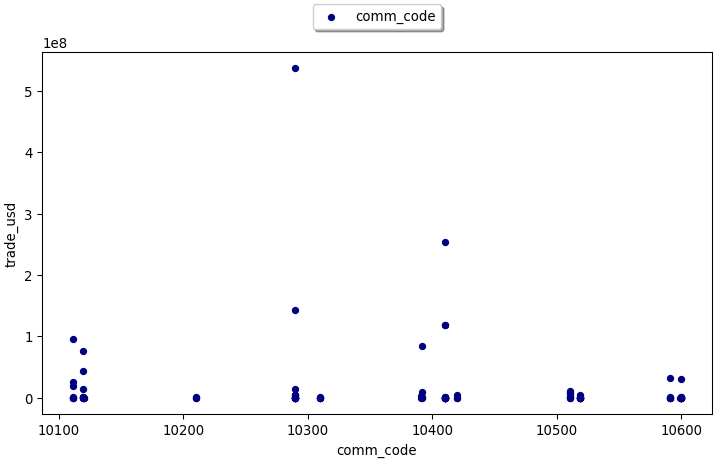

In [16]:
# Display visualization of prediction
display(predictions)

![clusterscatterplot](img/clusterscatterplot.png)

![clusterbar](img/clusterbar.png)